In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, confusion_matrix
from scipy.special import expit  # Import for numerically stable sigmoid
import matplotlib.pyplot as plt

In [3]:
# Load data without target variable
data = pd.read_csv('Full-EEG.csv')  # Replace with your CSV file
X = data.values  # Feature data

In [4]:

# Simulate a target variable for demonstration purposes
np.random.seed(42)
target = np.random.randint(0, 2, size=len(X))  # Simulate a binary target variable

In [5]:
# Initialize DataFrame to store results
metrics_df = pd.DataFrame(columns=[
    'Algorithm', 'Accuracy', 'Sensitivity', 'Specificity', 'MSR', 'GMean', 'FPR', 'Error Rate', 'Precision'
])

In [6]:
# Helper function to calculate additional metrics
def calculate_metrics(y_true, y_pred, mse):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    gmean = np.sqrt(sensitivity * specificity)
    fpr = fp / (fp + tn)
    error_rate = 1 - accuracy
    precision = precision_score(y_true, y_pred)
    return accuracy, sensitivity, specificity, mse, gmean, fpr, error_rate, precision


In [7]:
# Firefly Algorithm
class FireflyAlgorithm:
    def __init__(self, func, dim, lb, ub, n_fireflies=20, max_iter=100, alpha=0.5, beta=0.2, gamma=1.0):
        self.func = func  # Objective function
        self.dim = dim  # Dimension of the search space
        self.lb = lb  # Lower bound of variables
        self.ub = ub  # Upper bound of variables
        self.n_fireflies = n_fireflies  # Number of fireflies
        self.max_iter = max_iter  # Maximum iterations
        self.alpha = alpha  # Randomness factor
        self.beta = beta  # Attraction factor
        self.gamma = gamma  # Light absorption coefficient

    def optimize(self):
        # Initialize fireflies randomly
        fireflies = np.random.uniform(self.lb, self.ub, (self.n_fireflies, self.dim))
        intensities = np.array([self.func(f) for f in fireflies])

        for t in range(self.max_iter):
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if intensities[j] < intensities[i]:
                        # Move firefly i towards firefly j
                        r = np.linalg.norm(fireflies[i] - fireflies[j])
                        beta = self.beta * np.exp(-self.gamma * r**2)
                        fireflies[i] += beta * (fireflies[j] - fireflies[i]) + \
                                        self.alpha * (np.random.rand(self.dim) - 0.5) * (self.ub - self.lb)
                        fireflies[i] = np.clip(fireflies[i], self.lb, self.ub)
                        intensities[i] = self.func(fireflies[i])

        # Return the best solution
        best_idx = np.argmin(intensities)
        return fireflies[best_idx], intensities[best_idx]

In [8]:
# 1. Linear Regression with Firefly Optimization
def linear_regression_cost(params):
    model = LinearRegression()
    model.coef_ = params[:-1]
    model.intercept_ = params[-1]
    predictions = model.predict(X)
    return mean_squared_error(target, predictions)

fa_linear = FireflyAlgorithm(func=linear_regression_cost, dim=X.shape[1] + 1, lb=-10, ub=10)
solution_linear, score_linear = fa_linear.optimize()
predictions_linear = np.round(LinearRegression().fit(X, target).predict(X))
metrics_linear = calculate_metrics(target, predictions_linear, score_linear)
metrics_df.loc[len(metrics_df)] = ['Linear Regression (Firefly)'] + list(metrics_linear)

In [9]:
# 2. Non-Linear Regression (Polynomial) with Firefly Optimization
def poly_regression_cost(params, degree=2):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.coef_ = params[:-1][:X_poly.shape[1]]
    model.intercept_ = params[-1]
    predictions = model.predict(X_poly)
    return mean_squared_error(target, predictions)

dim_poly = PolynomialFeatures(2).fit_transform(X).shape[1] + 1
fa_poly = FireflyAlgorithm(func=lambda params: poly_regression_cost(params, degree=2), dim=dim_poly, lb=-10, ub=10)
solution_poly, score_poly = fa_poly.optimize()


In [10]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression().fit(X_poly, target)
predictions_poly = np.round(poly_model.predict(X_poly))
metrics_poly = calculate_metrics(target, predictions_poly, score_poly)
metrics_df.loc[len(metrics_df)] = ['Non-Linear Regression (Firefly)'] + list(metrics_poly)

# Logistic Regression with Firefly Optimization
logistic_model = LogisticRegression().fit(X, target)
target_classes = logistic_model.classes_

In [11]:
def logistic_regression_cost(params):
    model = LogisticRegression()
    model.classes_ = target_classes
    model.coef_ = params[:-1].reshape(1, -1)
    model.intercept_ = params[-1]
    decision_scores = model.decision_function(X)
    predictions = np.round(expit(decision_scores))  # Stable sigmoid
    return -accuracy_score(target, predictions)

fa_logistic = FireflyAlgorithm(func=logistic_regression_cost, dim=X.shape[1] + 1, lb=-10, ub=10)
solution_logistic, score_logistic = fa_logistic.optimize()

logistic_model_optimized = LogisticRegression()
logistic_model_optimized.coef_ = solution_logistic[:-1].reshape(1, -1)
logistic_model_optimized.intercept_ = solution_logistic[-1]
logistic_model_optimized.classes_ = target_classes

predictions_logistic = logistic_model_optimized.predict(X)
metrics_logistic = calculate_metrics(target, predictions_logistic, score_logistic)
metrics_df.loc[len(metrics_df)] = ['Logistic Regression (Firefly)'] + list(metrics_logistic)

Metrics saved to 'model_metrics_firefly.csv'


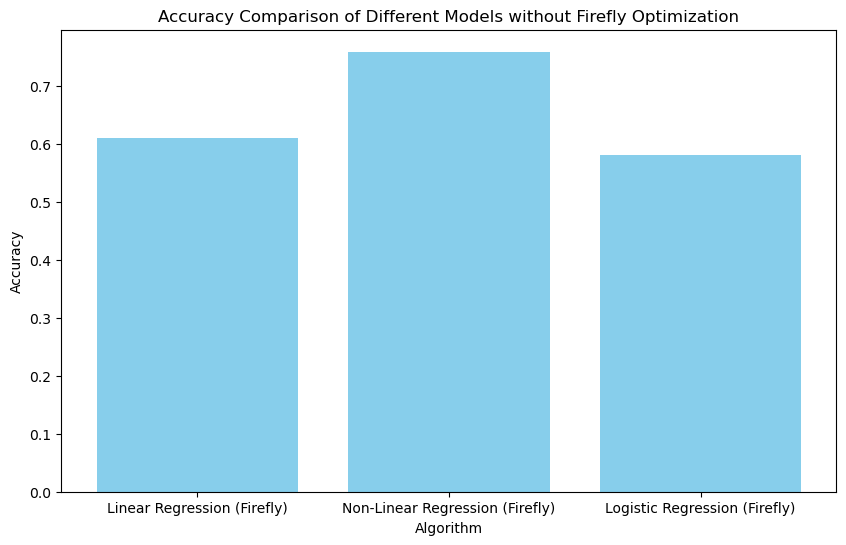

In [13]:
# Save the metrics to CSV file
metrics_df.to_csv('model_metrics_firefly.csv', index=False)
print("Metrics saved to 'model_metrics_firefly.csv'")

# Plotting graphs
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Algorithm'], metrics_df['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models without Firefly Optimization')
plt.show()

